In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import env

In [2]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'
query = '''
select logs.user_id as user, 
    cohorts.name as corhort_name, 
    logs.date, logs.time, 
    logs.path as endpoint, 
    logs.ip as source_ip, 
    cohorts.start_date,
    cohorts.end_date
from 
    logs 
    join cohorts
    on logs.cohort_id = cohorts.id;
'''
df = pd.read_sql(query, url)
df.head()

,user,corhort_name,date,time,endpoint,source_ip,start_date,end_date
0,1,Hampton,2018-01-26,09:55:03,/,97.105.19.61,2015-09-22,2016-02-06
1,1,Hampton,2018-01-26,09:56:02,java-ii,97.105.19.61,2015-09-22,2016-02-06
2,1,Hampton,2018-01-26,09:56:05,java-ii/object-oriented-programming,97.105.19.61,2015-09-22,2016-02-06
3,1,Hampton,2018-01-26,09:56:06,slides/object_oriented_programming,97.105.19.61,2015-09-22,2016-02-06
4,2,Teddy,2018-01-26,09:56:24,javascript-i/conditionals,97.105.19.61,2018-01-08,2018-05-17


In [3]:
# set date column as datetime dtype
df.date = pd.to_datetime(df.date)
df = df.set_index(df.date)
# new array called pages that represents the number of page views for each day
pages = df['endpoint'].resample('d').count()
pages.head()

date
2018-01-26    533
2018-01-27    230
2018-01-28    168
2018-01-29    783
2018-01-30    614
Freq: D, Name: endpoint, dtype: int64

<AxesSubplot:xlabel='date'>

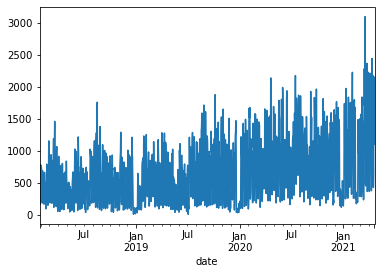

In [4]:
pages.plot()

In [5]:
# 7 days 
ema_7d = pages.ewm(span=7).mean()
ema_7d.head()

date
2018-01-26    533.000000
2018-01-27    359.857143
2018-01-28    276.891892
2018-01-29    461.982857
2018-01-30    511.811780
Freq: D, Name: endpoint, dtype: float64

In [6]:
# 30 days 
ema_30d = pages.ewm(span=30).mean()
ema_30d.head()

date
2018-01-26    533.000000
2018-01-27    376.450000
2018-01-28    302.284709
2018-01-29    434.739290
2018-01-30    475.525441
Freq: D, Name: endpoint, dtype: float64

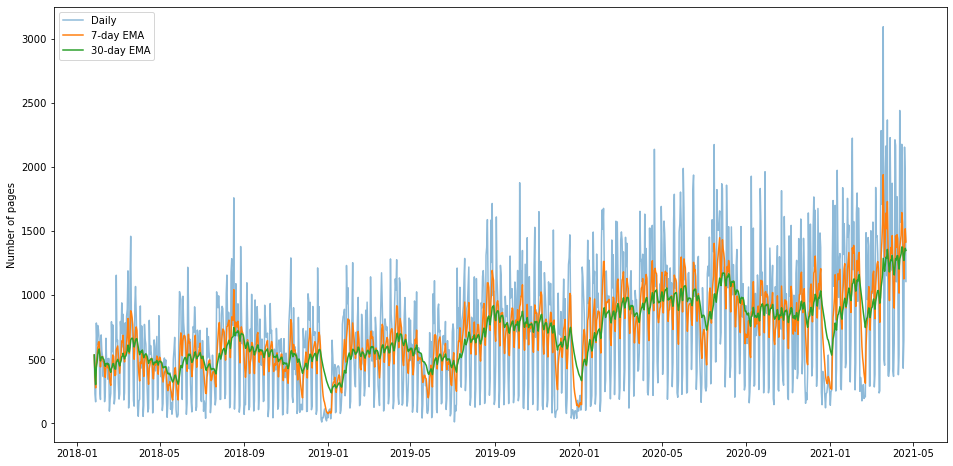

In [7]:
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

### Bollinger Bands

In [8]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()

midband.head()

date
2018-01-26    533.000000
2018-01-27    376.450000
2018-01-28    302.284709
2018-01-29    434.739290
2018-01-30    475.525441
Freq: D, Name: endpoint, dtype: float64

In [9]:
# compute exponential stdev
stdev = pages.ewm(span=span).std()

stdev.head()

date
2018-01-26           NaN
2018-01-27    214.253355
2018-01-28    192.738756
2018-01-29    292.489456
2018-01-30    262.780177
Freq: D, Name: endpoint, dtype: float64

In [10]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3
ub, lb

(date
 2018-01-26            NaN
 2018-01-27    1019.210064
 2018-01-28     880.500977
 2018-01-29    1312.207658
 2018-01-30    1263.865971
                  ...     
 2021-04-17    3539.572262
 2021-04-18    3480.391221
 2021-04-19    3565.644683
 2021-04-20    3575.685641
 2021-04-21    3495.320435
 Freq: D, Name: endpoint, Length: 1182, dtype: float64,
 date
 2018-01-26           NaN
 2018-01-27   -266.310064
 2018-01-28   -275.931559
 2018-01-29   -442.729079
 2018-01-30   -312.815089
                  ...    
 2021-04-17   -912.134710
 2021-04-18   -938.465770
 2021-04-19   -909.520874
 2021-04-20   -843.053691
 2021-04-21   -796.148610
 Freq: D, Name: endpoint, Length: 1182, dtype: float64)

In [11]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']
bb.head()

,ub,lb
date,,
2018-01-26,NaN,NaN
2018-01-27,1019.210064,-266.310064
2018-01-28,880.500977,-275.931559
2018-01-29,1312.207658,-442.729079
2018-01-30,1263.865971,-312.815089


In [12]:
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head

<bound method NDFrame.head of             pages      midband           ub          lb
date                                                   
2018-01-26    533   533.000000          NaN         NaN
2018-01-27    230   376.450000  1019.210064 -266.310064
2018-01-28    168   302.284709   880.500977 -275.931559
2018-01-29    783   434.739290  1312.207658 -442.729079
2018-01-30    614   475.525441  1263.865971 -312.815089
...           ...          ...          ...         ...
2021-04-17    430  1313.718776  3539.572262 -912.134710
2021-04-18    651  1270.962726  3480.391221 -938.465770
2021-04-19   2156  1328.061905  3565.644683 -909.520874
2021-04-20   1921  1366.315975  3575.685641 -843.053691
2021-04-21   1107  1349.585912  3495.320435 -796.148610

[1182 rows x 4 columns]>

In [13]:
my_df.head()

,pages,midband,ub,lb
date,,,,
2018-01-26,533,533.000000,NaN,NaN
2018-01-27,230,376.450000,1019.210064,-266.310064
2018-01-28,168,302.284709,880.500977,-275.931559
2018-01-29,783,434.739290,1312.207658,-442.729079
2018-01-30,614,475.525441,1263.865971,-312.815089


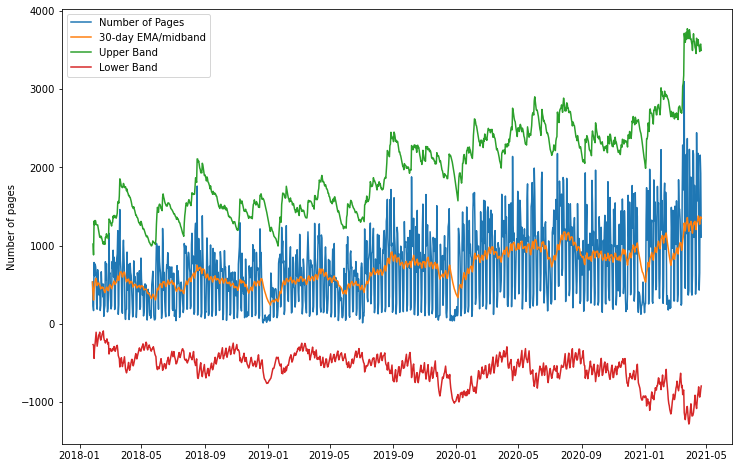

In [14]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

#### Compute %b

In [15]:
# value of last record
last_measure = my_df.iloc[-1].pages
last_measure

1107.0

In [16]:
# lower band on last date 
last_lb = my_df.iloc[-1].lb
last_lb

-796.1486103269135

In [17]:
# upper band value 
last_ub = my_df.iloc[-1].ub
last_ub

3495.320435064684

In [18]:
# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.44


In [19]:
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

my_df.head()

,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-26,533,533.000000,NaN,NaN,NaN
2018-01-27,230,376.450000,1019.210064,-266.310064,0.386077
2018-01-28,168,302.284709,880.500977,-275.931559,0.383880
2018-01-29,783,434.739290,1312.207658,-442.729079,0.698446
2018-01-30,614,475.525441,1263.865971,-312.815089,0.587827


In [20]:
my_df[my_df['pct_b']>1]

,pages,midband,ub,lb,pct_b
date,,,,,
